# À propos de ce livret

Explication de la méthode *Structured low-rank matrix completion for forecasting in time series analysis (SLRMC)*
- Embed a time series into a Hankel matrix and the missing data (to be forecasted) are stored in the bottom right-hand corner of this matrix.
- Consider a matrix completion problem for Hankel matrices.
- Choose a proper weighting scheme for the known observations.



Recherches liées au développement de cette méthode : 
>Jonathan Gillard, Konstantin Usevich (2018). **Structured low-rank matrix completion for forecasting in time series analysis**.


La méthode implantés provient de ces sources : 
>[**Dépôt 1**](https://github.com/xinychen/transdim/) | *Version en python*



**Note sur le cachier**
- Arranger le modèle pour des multiséries
- Définir les variables utilisées

# Préparation préalable à l'utilisation



In [1]:
# Utilités
import os
import time
import numpy as np
from numpy.linalg import inv as inv

# Chargement des données
import scipy.io

# Barre de progression
from tqdm.auto import trange
from tqdm import tqdm_notebook, notebook

# Présentation des résultats
import matplotlib.pyplot as plt

In [2]:
os.chdir("C:/Users/amass/OneDrive/02_Education/02_Maitrise/Cours/PROJET_MAITRISE/application")

# Données

## Chargement des données

In [3]:
# Chargement du tenseur de données
tensor = scipy.io.loadmat('data/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']

# Chargement de la matrice aléatoire de données
random_matrix = scipy.io.loadmat('data/Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']

# Chargement du tenseur aléatoire de données
random_tensor = scipy.io.loadmat('data/Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

print("Tensor shape : {:} | Random matrix shape : {:} | Random tensor shape : {:}".format(tensor.shape, 
                                                                                        random_matrix.shape,
                                                                                        random_tensor.shape))

Tensor shape : (214, 61, 144) | Random matrix shape : (214, 61) | Random tensor shape : (214, 61, 144)


## Format des données

In [4]:
petit_donnees = True

# Paramètres du jeu de données tronqué
capteurs = 50
jours = 10
sequences = tensor.shape[2]

matrice = True

if petit_donnees == True:
    tensor = tensor[0:capteurs, 0:jours, 0:sequences]
    
    random_tensor = random_tensor[0:capteurs, 0:jours, 0:sequences]
    

print("The tensors shapes are : {:} | {:}".format(tensor.shape, random_tensor.shape))

if matrice == True:
    dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
    
    print("The matrix shape is : {:}".format(dense_mat.shape))

The tensors shapes are : (50, 10, 144) | (50, 10, 144)
The matrix shape is : (50, 1440)


## Scénario de manquants

In [5]:
missing_rate = 0.4

random_missing = True

# Revoir le code pour que les deux choix puissent être respectés sur l'ensemble des matrices/ tenseurs
if random_missing == True:
    print("Random missing (RM) scenario")
    binary_mat = (np.round(random_tensor + 0.5 - missing_rate)
                  .reshape([random_tensor.shape[0], random_tensor.shape[1] * random_tensor.shape[2]]))
    print("\nBinary matrix shape : {:}".format(binary_mat.shape))
else:
    print("Non-random missing (NM) scenario")
    binary_tensor = np.zeros(tensor.shape)
    for i1 in range(tensor.shape[0]):
        for i2 in range(tensor.shape[1]):
            binary_tensor[i1, i2, :] = np.round(random_matrix[i1, i2] + 0.5 - missing_rate)
    binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] * binary_tensor.shape[2]])
    print("\nBinary matrix shape : {:}".format(binary_mat.shape))

sparse_mat = np.multiply(dense_mat, binary_mat)

Random missing (RM) scenario

Binary matrix shape : (50, 1440)


In [6]:
# Pour la présentation, n'utiliser qu'une seule ligne de données
data_line = dense_mat[0, - 9 * 144 :]

# Modélisation

In [7]:
def scale_to_data(vec, alpha):
    """
    
    
    """
    dim = vec.shape[0]
    new_vec = np.zeros(dim)
    for i in range(dim):
        new_vec[i] = vec[i] * np.exp((i + 1) * alpha / 2)
    return new_vec

def scale_back_data(vec, alpha):
    """
    
    
    """
    dim = vec.shape[0]
    new_vec = np.zeros(dim)
    for i in range(dim):
        new_vec[i] = vec[i] * np.exp(- (i + 1) * alpha / 2)
    return new_vec

In [8]:
def hankel(vec, window_length):
    """
    
    """
    column_num = vec.shape[0] - window_length + 1
    hankel_mat = np.zeros((window_length, column_num))
    for i in range(window_length):
        hankel_mat[i, :] = vec[i : column_num + i]
    return hankel_mat

def hankel2vec(mat):
    """
    
    
    """
    dim1, dim2 = mat.shape
    new_mat = np.zeros((dim1, dim1 + dim2 - 1))
    for i in range(dim1):
        new_mat[i, i : dim2 + i] = mat[i, :]
    return np.true_divide(new_mat.sum(0), (new_mat != 0).sum(0))

def svt(mat, tau):
    """
    
    
    """
    [m,n] = mat.shape
    if 2 * m < n:
        u, s, v = np.linalg.svd(mat @ mat.T, full_matrices = 0)
        s = np.sqrt(s)
        tol = n * np.finfo(float).eps * np.max(s)
        idx = np.sum(s > max(tau, tol))
        mid = (s[:idx] - tau) / s[:idx]
        return (u[:,:idx] @ np.diag(mid)) @ (u[:,:idx].T @ mat)
    elif m > 2 * n:
        return svt(mat.T, tau).T
    u, s, v = np.linalg.svd(mat, full_matrices = 0)
    idx = np.sum(s > tau)
    return u[:,:idx] @ np.diag(s[:idx]-tau) @ v[:idx,:]
    


In [9]:
def SLRMC(vec, window_length, forecast_horizon, rho, maxiter):
    """
    Structured low-rank matrix completion for forecasting in time series analysis
    
    Paramètres en entré : 
        vec : 
        window_length : 
        forecast_horizon : 
        rho : 
        maxiter : Nombre maximal d'itérations
    
    Paramètres en sortie : 
        vec_hat : 
    
    
    """
    
    
    mat = hankel(np.append(vec, np.zeros(forecast_horizon)), window_length)
    pos_missing = np.where(mat == 0)
    dim1, dim2 = mat.shape
    T = np.zeros((dim1, dim2))
    Z = mat.copy()
    for it in notebook.tqdm(range(maxiter)):
        X = svt(Z - T / rho, 1 / rho)
        Z[pos_missing] = (X + T / rho)[pos_missing]
        T = T + rho * (X - Z)
        vec_hat = hankel2vec(X)
    return vec_hat

In [10]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

## Partie 2.2 : Entrainement du modèle

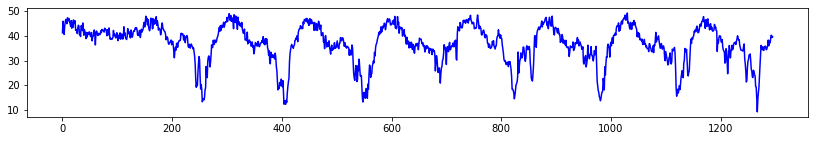

In [11]:
%matplotlib inline

fig = plt.figure(figsize = (14, 2))
plt.plot(data_line, color = "b")
plt.show()

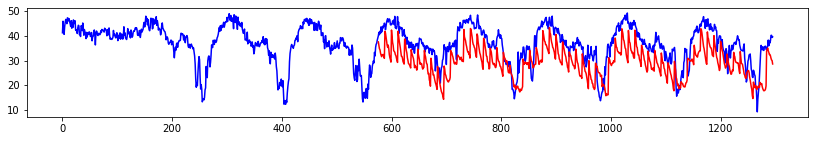

In [12]:
steps = 5 * 144 / 12
alpha = - 0.005
window_length = 144
forecast_horizon = 12
rho = 0.05
maxiter = 10

data_hat = np.zeros(np.int(steps * forecast_horizon))

for i in notebook.tqdm(range(np.int(steps))):
    y = data_line[: 4 * 144 + 12 * i]
    y_tilde = scale_to_data(y, alpha)
    x = SLRMC(y_tilde, window_length, forecast_horizon, rho, maxiter)
    y_hat = scale_back_data(x, alpha)
    data_hat[forecast_horizon * i : forecast_horizon * (i + 1)] = y_hat[- forecast_horizon :]
    
    if (i + 1) % 60 == 0:
        fig = plt.figure(figsize = (14, 2))
        plt.plot(data_line, color = "b")
        plt.plot(np.arange(4 * 144, 9 * 144), data_hat, color = 'r')
        plt.show()



In [13]:
mape = compute_mape(data_line[4 * 144 :], data_hat)
rmse = compute_rmse(data_line[4 * 144 :], data_hat)
print('Prediction MAPE: {:.6}'.format(mape))
print('Prediction RMSE: {:.6}'.format(rmse))

Prediction MAPE: 0.214777
Prediction RMSE: 8.83061
